# FDM testing notebook: mass conservation

This notebook uses sythetic data to test mass conservation for the finite-difference method implemented  in the code. Note other testing as done but needs to be cleaned up before being added to the package.



In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from advdiff_mcmc.advdiff.fd_utils import generate_grid, calc_Ks, calc_Ks_new
from advdiff_mcmc.advdiff.fdm_implement import obj_CN
from advdiff_mcmc.advdiff.fd_methods import eflux_mod1, CN_coefficients, conc_etxr

from wutils.plotnice import plot_align

sns.set()
sns.set_style("white")
sns.set_style("ticks")

## Create the synthetic forcing data

In [65]:
del_z = 1.0
h_tot = 16.0

del_t = 300.0
T_tot = 24*60*60

bbl_h = 15

km_bg = 0.0 # 10**-4 #this needs to be zero for mass conservation testing

fg, mg, tg = generate_grid(h_tot, del_z, T_tot, del_t) 
print('Grid size = ', str(len(mg)), ' x ', str(len(tg)))

lmbda, alpha, beta = CN_coefficients(tg, mg)

Grid size =  16  x  289


In [75]:
# Specify a u* time series for diffusivity profile
f_wave = 0.17*np.sin(np.linspace(-np.pi/2,7.5*np.pi,len(tg))) + 0.20

u_bed = np.sqrt((f_wave)**2 * 0.00185)
t_bed = 1035*u_bed**2

# Calculate diffusivity profile
Ks_all = calc_Ks(u_bed, fg, np.repeat(bbl_h, len(tg)), km_bg)
Ks_new = calc_Ks_new(u_bed, fg, np.repeat(bbl_h, len(tg)), km_bg)

## Compare old and new diffusivity functions

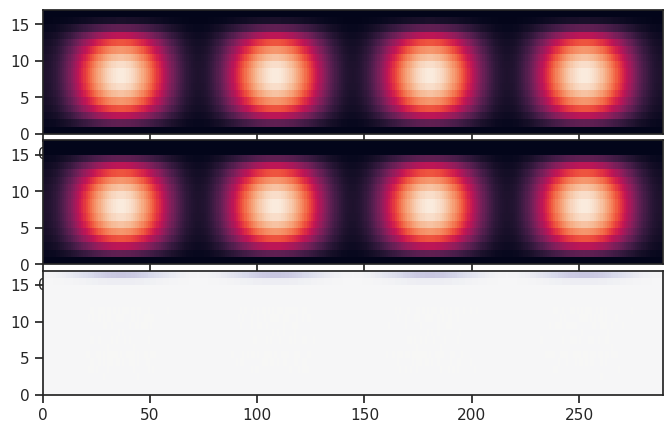

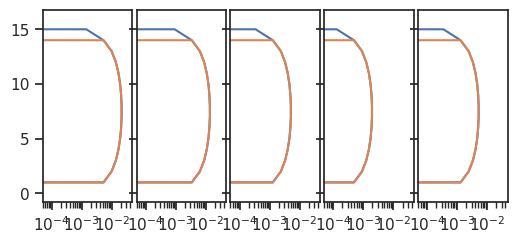

In [76]:
vmx = np.max([np.max(Ks_all), np.max(Ks_new)])

fig, ax = plt.subplots(3, 1, figsize=(8,5), gridspec_kw={'hspace':0.05})
ax[0].pcolormesh(Ks_all.T, vmin=0, vmax=vmx)
ax[1].pcolormesh(Ks_new.T, vmin=0, vmax=vmx)
ax[2].pcolormesh(Ks_all.T - Ks_new.T, vmin=-vmx, vmax=vmx, cmap='PuOr')

fig, ax = plt.subplots(1, 5, figsize=(6,2.5), gridspec_kw={'wspace':0.05})
for x, ix in zip(ax, np.linspace(len(tg)/10, len(tg)-10, 5)):
    x.plot(Ks_all[int(ix),:], fg)
    x.plot(Ks_new[int(ix),:], fg)
    x.set_xlim(10**-4/2, vmx*2)
    x.set_xscale('log')
    if x != ax[0]:
        x.set_yticklabels('')

The new forumla for diffusivity is a bit weird, sticking with the old one for now. 

## Create the synthetic SSC data

#### Pick some realistic parameters from literature

In [77]:
w_s = 1.0 # [x10-3 m/s]
t_c = 7.0 # [x10-2 Pa]
e_0 = 3.0 # [x10-4 g/m2/s]
m_c = None
b_c = 1.1 # close to one makes the model difficult to sample

theta_syn = [w_s, e_0, t_c, m_c, b_c, 0]
# theta_syn = [1.64872127, 15.95769122, 2.39365368, 0., 1.28402542, 2.39365368]

In [78]:
# Run the model once to get initial profile
model_spec = [tg, mg, fg, np.zeros_like(mg), Ks_all, h_tot, t_bed]

syn_init = obj_CN(theta_syn, 'E1', model_spec)
cn_rn = syn_init[-1,:]

# Run the model again to get the final synthetic data
model_spec = [tg, mg, fg, cn_rn, Ks_all, h_tot, t_bed]
syn_final = obj_CN(theta_syn, 'E1', model_spec)

obs_htx = ((mg >= 0.4) & (mg <= 0.6)) | ((mg >= 8.4) & (mg <= 8.6))

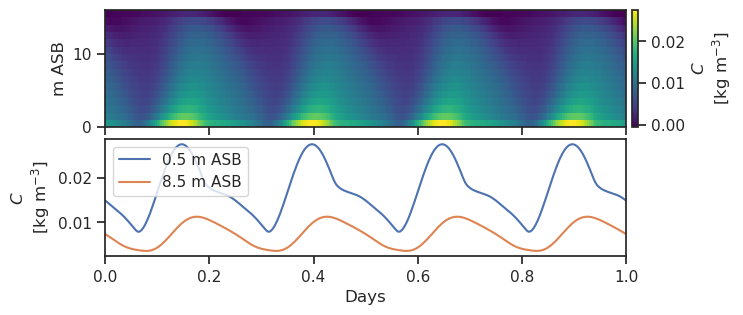

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(8,3.2))
plt.subplots_adjust(hspace=0.1)
pc=ax[0].pcolormesh(tg/60/60/24, mg, syn_final.T, cmap=cm.viridis)
cb2 = fig.colorbar(pc, ax=ax[0], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$C$\n[kg m$^{-3}$]')
ax[0].set_ylabel('m ASB')

ax[1].plot(tg/60/60/24, syn_final.T[obs_htx][0], label=str(mg[obs_htx][0]) + ' m ASB')
ax[1].plot(tg/60/60/24, syn_final.T[obs_htx][-1], label=str(mg[obs_htx][-1]) + ' m ASB')
ax[1].legend()

ax[1].set_ylabel('$C$\n[kg m$^{-3}$]')
ax[1].set_xlabel('Days')

for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')
plot_align(ax)

### Check the model isn't losing tracer

In [80]:
# Compute the erosion and deposition
c_for = np.zeros_like(tg)
c_bak = np.zeros_like(tg)
c_total = np.sum(syn_final, axis=1)
d_all = np.zeros_like(tg)

for ix, tb in enumerate(t_bed[:-1]):
    if tb > t_c/10**2:
        c_for[ix] = beta*eflux_mod1(tb, t_c/10**2, e_0/10**4, b_c)

    if t_bed[ix+1] > t_c/10**2:
        c_bak[ix] = beta*eflux_mod1(t_bed[ix+1], t_c/10**2, e_0/10**4, b_c)

    d_all[ix] = 2*beta*(w_s/10**3)*conc_etxr(syn_final.T[:,ix])

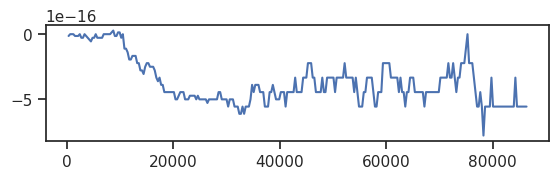

In [81]:
# Plot the total minus the input
fig, ax = plt.subplots(1, 1, figsize=(6.5,1.5))
plt.plot(tg[1:], c_total[1:] - np.cumsum(c_for + c_bak)[:-1] + np.cumsum(d_all)[:-1] - c_total[0])


Looks like the model is conservative down to very small amounts.

Note: much more testing was done in the original notebooks I wrote. I should dig out all that stuff one day as some of it was pretty interesting (order of error, comparison to analytical solutions, and much more testing on conservation of mass)

## Add noise to the synthetic SSC


In [82]:
obs_mod = np.copy(syn_final)

noise_sd = 2/1000
noise_meas = np.random.normal(0, noise_sd, np.shape(obs_mod))
obs_meas = obs_mod + noise_meas

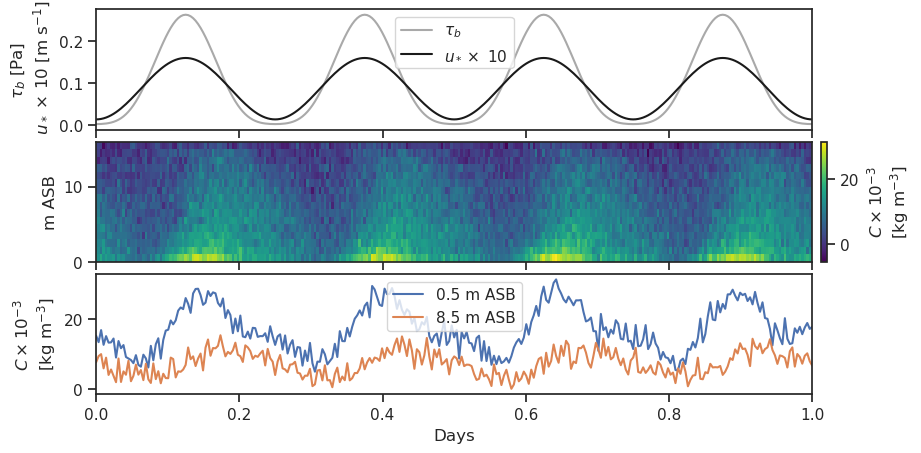

In [83]:
fig, ax = plt.subplots(3, 1, figsize=(11,5))
plt.subplots_adjust(hspace=0.1)

ax[0].plot(tg/60/60/24, t_bed, label='$\\tau_b$', c='darkgrey')
ax[0].plot(tg/60/60/24, 10*u_bed, label=r'$u_* \times$ 10', c='k')

ax[0].set_ylabel('$\\tau_b$ [Pa]\n $u_*$ $\\times$ 10 [m s$^{-1}$]')
ax[0].legend()

pc=ax[1].pcolormesh(tg/60/60/24, mg, 1000*obs_meas.T, cmap=cm.viridis)
cb2 = fig.colorbar(pc, ax=ax[1], pad=0.01)
mpl.colorbar.ColorbarBase.set_label(cb2, '$C \\times 10^{-3}$\n[kg m$^{-3}$]')

ax[1].set_ylabel('m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][0]*1000, label=str(mg[obs_htx][0]) + ' m ASB')
ax[2].plot(tg/60/60/24, obs_meas.T[obs_htx][-1]*1000, label=str(mg[obs_htx][-1]) + ' m ASB')
ax[2].legend()

ax[2].set_ylabel('$C \\times 10^{-3}$\n[kg m$^{-3}$]')
ax[2].set_xlabel('Days')

ax_zero = ax[1].get_position().bounds
for x in ax:
    x.set_xlim(0, tg[-1]/60/60/24)
    if x != ax[-1]:
        x.set_xlabel('')
        x.set_xticklabels('')

    if x != ax[1]:
        ax_one = x.get_position().bounds
        x.set_position([ax_zero[0], ax_one[1], ax_zero[2], ax_one[3]])